In [1]:
import pandas as pd
import numpy as np
import json,os
from glob import glob
from datetime import datetime,date

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
# This gives me the white canvas, ticks, also the Arial font family
sns.set_context('talk') 
style.use('seaborn-deep')

import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates.default = "none"

# 1. Data Extracting and Processing

## 1-1. Retrieving Speed Test Data

In [2]:
# Reference: https://github.com/tarunmangla/CABI-60GHz-Measurement/blob/main/scripts/get_speedtest_data.ipynb
# variables for counting errors in parsing or the speedtest measurements 
count = 0
missed_count = 0
error_count_map = {}

# logs the errors for each speedtest
def log_error_speedtest(speedtest):
    global error_count_map
    if speedtest not in error_count_map:
        error_count_map[speedtest] = 0
    error_count_map[speedtest] += 1

def measurement_error(measurement, speedtest):
    if speedtest == "iperf" or speedtest == "oplat":
        if measurement["error"] == True:
            log_error_speedtest(speedtest)
            return True
    elif "error" in measurement:
        print(measurement)
        log_error_speedtest(speedtest)
        return True
    
    return False

def get_subkeys(speedtest):
    speedtest_map = {
                        "ookla": ("speedtest_ookla_download", "speedtest_ookla_upload", "speedtest_ookla_server_host"),
                        "ndt7": ("speedtest_ndt7_download", "speedtest_ndt7_upload", "speedtest_ndt7_server"),
                        # "iperf": ("iperf_udp_download", "iperf_udp_upload"),
                        # "oplat": ("avg_rate_tcp_probes_dl", "avg_rate_tcp_probes_ul")
                    }
    return speedtest_map[speedtest]

speedtest_protocols = ["ookla", "ndt7", 
                       #"iperf", "oplat"
]

# returns the speedtest data from a given file
# output: [user_id, timestamp, speedtest_type, downlink_tput, uplink_tput]

def get_speedtest(filename):
    global count, missed_count
    count += 1
    try:
        json_data = json.load(open(filename))
    except:
        missed_count += 1
        return []
    
    measurement_data = json_data["Measurements"]
    metadata = [json_data["Meta"]["Id"], json_data["Meta"]["Time"]]
    speedtest_result_list = []
    for speedtest in speedtest_protocols:
        # check if speedtest is present and there is no error
        if speedtest not in measurement_data or measurement_error(measurement_data[speedtest], speedtest):
            continue 
        #print(measurement_data[speedtest])
        # subfield to access the download measurement
        subkey_list = get_subkeys(speedtest)
        
        measurement_values = [measurement_data[speedtest][subkey] for subkey in subkey_list if subkey in measurement_data[speedtest]]
            
        speedtest_result = metadata + [speedtest] + measurement_values
        speedtest_result_list.append(speedtest_result) 
    return speedtest_result_list


def get_speedtest_data(BASE_DIR_LIST, USER_LIST, DATE_LIST):
    files_to_process = []
    for BASE_DIR in BASE_DIR_LIST:
        for user in USER_LIST:
            for date in DATE_LIST:
                files_to_process += glob(f"{BASE_DIR}/{user}/{date}/json/nm_data_*_netrics_results.json")
    
    speedtest_data = []
    for i in range(0, len(files_to_process)):
        f_processed = float(i)/len(files_to_process)*100
        if i % 300 == 0:
            print(f"processed {round(f_processed)}% of all the {len(files_to_process)} files")
        filename = files_to_process[i]
        speedtest_data += get_speedtest(filename)

    cols = ["ID", "Timestamp", "Type", "Down", "Up", "Server"]
    df = pd.DataFrame(speedtest_data, columns=cols)
    df['datetime'] = list(map(lambda t:datetime.fromtimestamp(t).strftime("%Y-%m-%d %H:%M:%S"), df['Timestamp']))
    
    return df.sort_values(by = 'datetime')

In [3]:
BASE_DIR = "/scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-netrics/"
DATA_DIR_LIST = [f"{BASE_DIR}/beta/"]
DEVICE_LIST = ['nm-mngd-20220628-07c02d28','nm-mngd-20210518-0ca06c37'] # 'nm-mngd-20220628-52b7dbb9' is not in use.
DATE_LIST = list(pd.date_range(
    date(2022,7,1), 
     datetime.today().date()
).strftime("%Y%m%d"))


In [4]:
df = get_speedtest_data(DATA_DIR_LIST, DEVICE_LIST, DATE_LIST)
df

processed 0% of all the 4137 files
processed 7% of all the 4137 files
processed 15% of all the 4137 files
processed 22% of all the 4137 files
processed 29% of all the 4137 files
processed 36% of all the 4137 files
processed 44% of all the 4137 files
processed 51% of all the 4137 files
processed 58% of all the 4137 files
{'error': '[2022-07-02 05:16:34.604] [error] Configuration - Timeout was reached (TimeoutException)\n[2022-07-02 05:16:34.604] [error] Configuration - Cannot retrieve configuration document (0)\n[2022-07-02 05:16:34.605] [error] ConfigurationError - Could not retrieve or read configuration (Configuration)\n[2022-07-02 05:16:34.605] [error] ConfigurationError - Could not retrieve or read configuration (Configuration)\n{"type":"log","timestamp":"2022-07-02T05:16:34Z","message":"Configuration - Could not retrieve or read configuration (ConfigurationError)","level":"error"}\n', 'ookla_error': True}
processed 65% of all the 4137 files
processed 73% of all the 4137 files
proc

ID     Timestamp   Type        Down          Up  \
21  nm-mngd-20210518-0ca06c37  1.656653e+09   ndt7  860.533174  909.251242   
20  nm-mngd-20210518-0ca06c37  1.656653e+09  ookla  873.885816  908.847096   
22  nm-mngd-20210518-0ca06c37  1.656739e+09   ndt7  859.370848  641.519027   
0   nm-mngd-20220628-07c02d28  1.656770e+09  ookla  938.663952  804.948448   
1   nm-mngd-20220628-07c02d28  1.656770e+09   ndt7  938.680734  797.185062   
24  nm-mngd-20210518-0ca06c37  1.656804e+09   ndt7  856.440638  813.662389   
23  nm-mngd-20210518-0ca06c37  1.656804e+09  ookla  805.278952  749.045752   
7   nm-mngd-20220628-07c02d28  1.656813e+09   ndt7  939.171577  791.326608   
6   nm-mngd-20220628-07c02d28  1.656813e+09  ookla  938.416912  834.100688   
32  nm-mngd-20210518-0ca06c37  1.656829e+09   ndt7  854.946279  913.329451   
31  nm-mngd-20210518-0ca06c37  1.656829e+09  ookla  793.374672  910.600752   
28  nm-mngd-20210518-0ca06c37  1.656851e+09   ndt7  586.473754  799.619649   
27  nm-mngd-20210518-0ca06c37  1.656851e+09  ookla  854.817024  921.508624   
30  nm-mngd-20210518-0ca06c37  1.656854e+09   ndt7  741.155916  808.621568   
29  nm-mngd-20210518-0ca06c37  1.656854e+09  ookla  675.613192  866.656864   
34  nm-mngd-20210518-0ca06c37  1.656858e+09   ndt7  867.223798  808.279835   
33  nm-mngd-20210518-0ca06c37  1.656858e+09  ookla  802.884960  915.501160   
4   nm-mngd-20220628-07c02d28  1.656878e+09  ookla  940.601000  920.886440   
5   nm-mngd-20220628-07c02d28  1.656878e+09   ndt7  914.639822  793.558440   
25  nm-mngd-20210518-0ca06c37  1.656890e+09  ookla  851.912992  894.703352   
26  nm-mngd-20210518-0ca06c37  1.656890e+09   ndt7  858.950718  812.745426   
3   nm-mngd-20220628-07c02d28  1.656892e+09   ndt7  939.157131  792.086768   
2   nm-mngd-20220628-07c02d28  1.656892e+09  ookla  941.201944  890.171016   
40  nm-mngd-20210518-0ca06c37  1.656951e+09   ndt7  854.003894  829.666593   
39  nm-mngd-20210518-0ca06c37  1.656951e+09  ookla  875.627840  913.740584   
9   nm-mngd-20220628-07c02d28  1.656953e+09   ndt7  933.562628  772.459273   
8   nm-mngd-20220628-07c02d28  1.656953e+09  ookla  942.324776  839.991520   
41  nm-mngd-20210518-0ca06c37  1.656959e+09  ookla  780.473280  915.820512   
42  nm-mngd-20210518-0ca06c37  1.656959e+09   ndt7  745.626280  828.129044   
37  nm-mngd-20210518-0ca06c37  1.656962e+09  ookla  805.909352  875.601976   
38  nm-mngd-20210518-0ca06c37  1.656962e+09   ndt7  860.214223  831.844582   
35  nm-mngd-20210518-0ca06c37  1.656977e+09  ookla  866.427296  908.536728   
36  nm-mngd-20210518-0ca06c37  1.656977e+09   ndt7  745.207837  831.221796   
43  nm-mngd-20210518-0ca06c37  1.657002e+09  ookla  825.902216  869.040984   
44  nm-mngd-20210518-0ca06c37  1.657002e+09   ndt7  863.121160  821.822522   
10  nm-mngd-20220628-07c02d28  1.657011e+09  ookla  939.043512  892.122416   
11  nm-mngd-20220628-07c02d28  1.657011e+09   ndt7  940.110892  901.779482   
13  nm-mngd-20220628-07c02d28  1.657025e+09   ndt7  939.192189  882.054722   
12  nm-mngd-20220628-07c02d28  1.657025e+09  ookla  939.554536  831.693328   
15  nm-mngd-20220628-07c02d28  1.657061e+09   ndt7  922.180789  803.625513   
14  nm-mngd-20220628-07c02d28  1.657061e+09  ookla  940.804488  829.153472   
16  nm-mngd-20220628-07c02d28  1.657076e+09  ookla  939.631032  891.518040   
17  nm-mngd-20220628-07c02d28  1.657076e+09   ndt7  930.608223  782.345749   
18  nm-mngd-20220628-07c02d28  1.657101e+09  ookla  942.085096  926.797720   
19  nm-mngd-20220628-07c02d28  1.657101e+09   ndt7  939.186784  785.441316   
45  nm-mngd-20210518-0ca06c37  1.657146e+09  ookla  770.873040  907.143592   
46  nm-mngd-20210518-0ca06c37  1.657146e+09   ndt7  817.507709  855.598891   

                                          Server             datetime  
21  ndt-mlab2-ord06.mlab-oti.measurement-lab.org  2022-07-01 00:16:34  
20                   speedtest.chi1.nitelusa.net  2022-07-01 00:16:34  
22  ndt-mlab3-ord03.mlab-oti.measurement-lab.org  2022-07-02 00:16

## 1-2. Retrieving Latency Data (Ping Latency & Last Mile Latency)

In [5]:
def get_latencytest(filename):
    global count, missed_count
    count += 1
    try:
        json_data = json.load(open(filename))
    except:
        missed_count += 1
        return []
    
    measurement_data = json_data["Measurements"]
    metadata = [json_data["Meta"]["Id"], json_data["Meta"]["Time"]]
    latencytest_result_list = []
    PING_LATENCY_METRICS_LIST = ['amazon_rtt_avg_ms','facebook_rtt_avg_ms','google_rtt_avg_ms']
    LAST_MILE_LATENCY_METRICS_LIST = ['Cloudflare_DNS_last_mile_ping_rtt_avg_ms']
    
    try:
        measurement_values = [measurement_data['ping_latency'][subkey] for subkey in PING_LATENCY_METRICS_LIST if subkey in measurement_data['ping_latency']] + \
            [measurement_data['last_mile_rtt'][subkey] for subkey in LAST_MILE_LATENCY_METRICS_LIST if subkey in measurement_data['last_mile_rtt']]
        latencytest_result = metadata + measurement_values
        latencytest_result_list.append(latencytest_result)     
    except KeyError as e:
        print(f"Key Error: {e}.\nFile Name: {filename}")        
        if ('ping_latency' in measurement_data) and ('last_mile_rtt' not in measurement_data):
            measurement_values = [measurement_data['ping_latency'][subkey] for subkey in PING_LATENCY_METRICS_LIST if subkey in measurement_data['ping_latency']]
            latencytest_result = metadata + measurement_values
            latencytest_result_list.append(latencytest_result)
            print("Only ping latency metrics were extracted.")

    return latencytest_result_list

def get_latencytest_data(BASE_DIR_LIST, USER_LIST, DATE_LIST):
    files_to_process = []
    for BASE_DIR in BASE_DIR_LIST:
        for user in USER_LIST:
            for date in DATE_LIST:
                files_to_process += glob(f"{BASE_DIR}/{user}/{date}/json/nm_data_*_netrics_results.json")
    
    latencytest_data = []
    for i in range(0, len(files_to_process)):
        f_processed = float(i)/len(files_to_process)*100
        if i % 300 == 0:
            print(f"processed {round(f_processed)}% of all the {len(files_to_process)} files")
        filename = files_to_process[i]
        latencytest_data += get_latencytest(filename)

    cols = ["ID", "Timestamp", "amazon_rtt_avg_ms", "facebook_rtt_avg_ms", "google_rtt_avg_ms",'Cloudflare_DNS_last_mile_ping_rtt_avg_ms']
    df = pd.DataFrame(latencytest_data, columns=cols)
    df['datetime'] = list(map(lambda t:datetime.fromtimestamp(t).strftime("%Y-%m-%d %H:%M:%S"), df['Timestamp']))
    return df.sort_values(by = 'datetime')


In [6]:
# Test & Debug code

# files_to_process = []
# for BASE_DIR in DATA_DIR_LIST:
#     for user in DEVICE_LIST:
#         for date in DATE_LIST:
#             files_to_process += glob(f"{BASE_DIR}/{user}/{date}/json/nm_data_*_netrics_results.json")

# filename = '/scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-netrics//beta//nm-mngd-20220628-07c02d28/20220701/json/nm_data_20220701_194405_netrics_results.json'
# filename = files_to_process[3]
# json.load(open(filename))

# t = 1656647766.752154
# datetime.fromtimestamp(t).strftime("%Y-%m-%d %H:%M:%S")            

In [7]:
df2 = get_latencytest_data(DATA_DIR_LIST, DEVICE_LIST, DATE_LIST)
df2

processed 0% of all the 4137 files
Key Error: 'last_mile_rtt'.
File Name: /scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-netrics//beta//nm-mngd-20220628-07c02d28/20220701/json/nm_data_20220701_194405_netrics_results.json
Only ping latency metrics were extracted.
Key Error: 'last_mile_rtt'.
File Name: /scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-netrics//beta//nm-mngd-20220628-07c02d28/20220701/json/nm_data_20220701_195007_netrics_results.json
Only ping latency metrics were extracted.
Key Error: 'last_mile_rtt'.
File Name: /scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-netrics//beta//nm-mngd-20220628-07c02d28/20220701/json/nm_data_20220701_094404_netrics_results.json
Only ping latency metrics were extracted.
Key Error: 'last_mile_rtt'.
File Name: /scratch/datasets/broadband/dev1/nm-exp-active-netrics/data/s3/sync/netrics_mngd/nm-exp-active-net

ID     Timestamp  amazon_rtt_avg_ms  \
2321  nm-mngd-20210518-0ca06c37  1.656634e+09             21.413   
215   nm-mngd-20220628-07c02d28  1.656634e+09             20.370   
83    nm-mngd-20220628-07c02d28  1.656634e+09             21.439   
2198  nm-mngd-20210518-0ca06c37  1.656634e+09             22.512   
197   nm-mngd-20220628-07c02d28  1.656634e+09              0.689   
...                         ...           ...                ...   
2095  nm-mngd-20220628-07c02d28  1.657181e+09              0.922   
4108  nm-mngd-20210518-0ca06c37  1.657181e+09             22.504   
2045  nm-mngd-20220628-07c02d28  1.657181e+09              0.931   
4078  nm-mngd-20210518-0ca06c37  1.657181e+09             22.362   
2039  nm-mngd-20220628-07c02d28  1.657181e+09              0.927   

      facebook_rtt_avg_ms  google_rtt_avg_ms  \
2321                  NaN                NaN   
215                   NaN                NaN   
83                 20.018             20.386   
2198               21.003             21.535   
197                20.011             20.361   
...                   ...                ...   
2095                1.888              1.891   
4108                2.967              2.902   
2045                1.882              1.898   
4078                2.865              2.890   
2039                1.879              1.902   

      Cloudflare_DNS_last_mile_ping_rtt_avg_ms             datetime  
2321                                       NaN  2022-06-30 19:00:05  
215                                        NaN  2022-06-30 19:00:07  
83                                       1.042  2022-06-30 19:01:05  
2198                                     3.678  2022-06-30 19:01:05  
197                                      1.042  2022-06-30 19:06:05  
...                                        ...                  ...  
2095                                     1.202  2022-07-07 02:56:02  
4108                                     1.922  2022-07-07 02:56:03  
2045                                     2.043  2022-07-07 03:01:02  
4078                                     2.040  2022-07-07 03:01:03  
2039                                     1.988  2022-07-07 03:06:02  

[4137 rows x 7 columns]

In [8]:
df2.to_csv("latency_test_0701_0703.csv")

# 2. Visualization

## 2-1. Speed Test

In [9]:
# --------------------------------------------------------------------------------
# Plotly Viz Function
# --------------------------------------------------------------------------------
def plot_speedtest_trend(df, x_col, y_col, title):
    '''
    Input:
        df
        pred_rate_range
        ...
    Output:
        fig (Plotly.graph figure object)
    '''        
    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig = go.Figure(layout = layout)

    # add ARMA predictions
    fig.add_trace(
        go.Scatter(
            x=list(df.loc[df.ID == 'nm-mngd-20220628-07c02d28',x_col]), 
            y=list(df.loc[df.ID == 'nm-mngd-20220628-07c02d28',y_col]),
            line_color='#41A317',
            mode = 'lines+markers',
            name='RPI(2d28)',
            showlegend=True,
            hovertemplate =
              '<b>SpeedTest: </b> %{y} Mbps'+
              '<br><b>Time: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>'
        )
    )

    # add SEM predictions
    fig.add_trace(
        go.Scatter(
        x=list(df.loc[df.ID == 'nm-mngd-20210518-0ca06c37',x_col]), 
        y=list(df.loc[df.ID == 'nm-mngd-20210518-0ca06c37',y_col]),
        line_color='#6698FF',
        mode = 'lines+markers',
        name='RPI(6c37)',
        showlegend=True,
        hovertemplate =
          '<b>SpeedTest: </b> %{y} Mbps'+
          '<br><b>Time: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
        )   
    )

    # Set the layout
    fig.update_layout(
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title="Time",
        yaxis_title="Mbps",
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=16,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            # type = "date"
        ),
        yaxis = dict(tickfont = dict(size = 16)),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )

    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text= title,
                                  font=dict(family='Arial',
                                            size=22,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig.update_layout(annotations=annotations)
    return fig

### Download

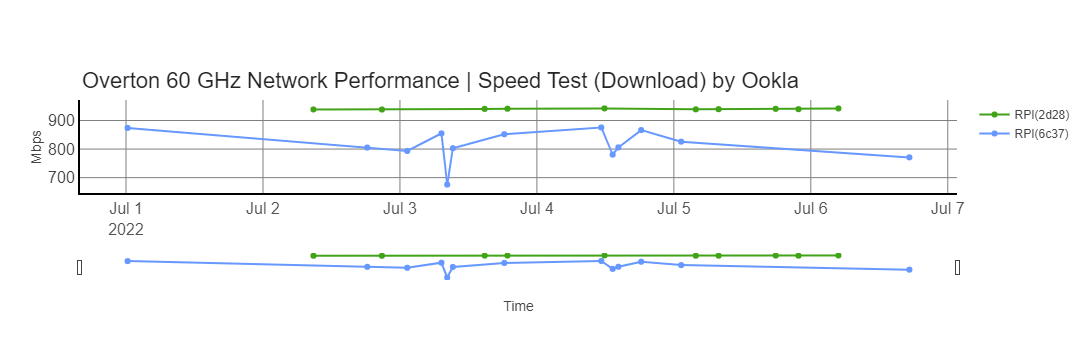

In [10]:
plot_speedtest_trend(
    df = df[df.Type == 'ookla'], 
    x_col = 'datetime', 
    y_col = 'Down', 
    title = 'Overton 60 GHz Network Performance | Speed Test (Download) by Ookla'
)

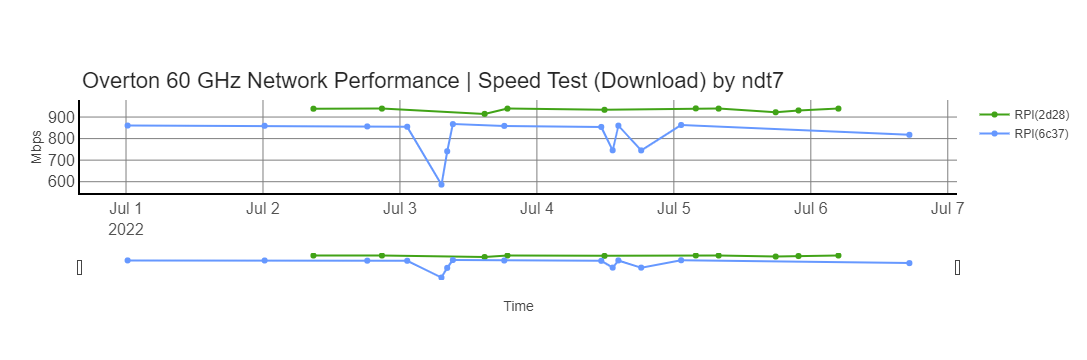

In [11]:
plot_speedtest_trend(
    df = df[df.Type == 'ndt7'], 
    x_col = 'datetime', 
    y_col = 'Down', 
    title = 'Overton 60 GHz Network Performance | Speed Test (Download) by ndt7'
)

### Upload

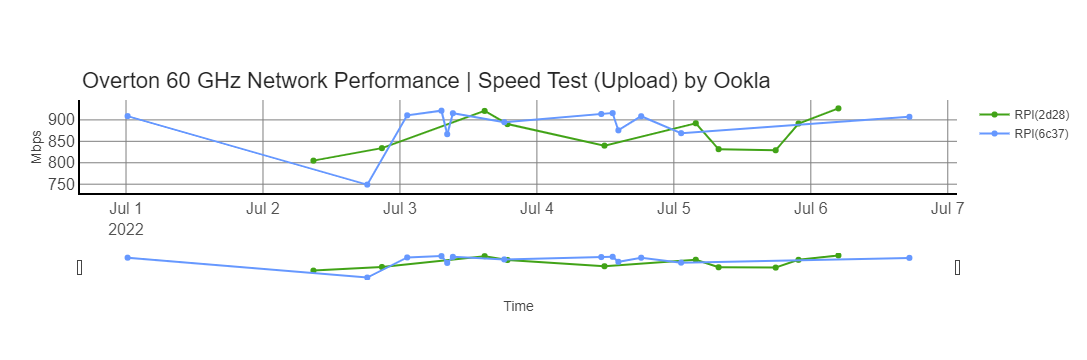

In [12]:

plot_speedtest_trend(
    df = df[df.Type == 'ookla'], 
    x_col = 'datetime', 
    y_col = 'Up', 
    title = 'Overton 60 GHz Network Performance | Speed Test (Upload) by Ookla'
)

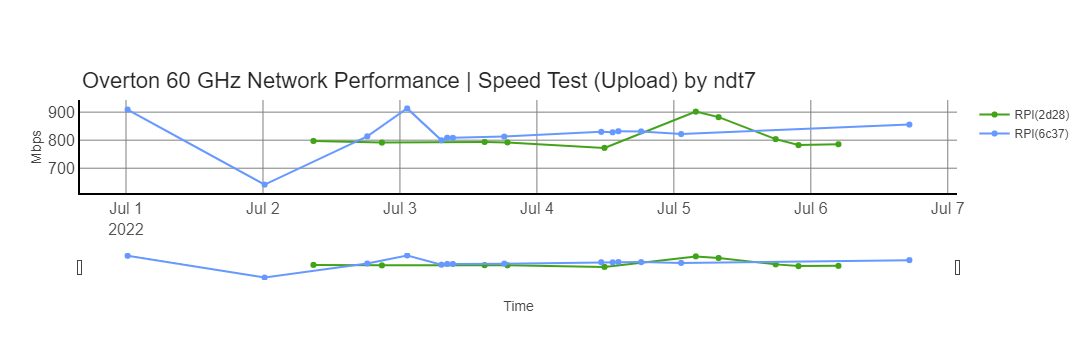

In [13]:
plot_speedtest_trend(
    df = df[df.Type == 'ndt7'], 
    x_col = 'datetime', 
    y_col = 'Up', 
    title = 'Overton 60 GHz Network Performance | Speed Test (Upload) by ndt7'
)

## 2-2. Latency Test

In [19]:
# --------------------------------------------------------------------------------
# Plotly Viz Function
# --------------------------------------------------------------------------------
def plot_latencytest_trend(df, x_col, y_col, title):
    '''
    Input:
        df
        pred_rate_range
        ...
    Output:
        fig (Plotly.graph figure object)
    '''        
    layout = Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig = go.Figure(layout = layout)

    # add trace 1: for device 2d28
    fig.add_trace(
        go.Scatter(
            x=list(df.loc[df.ID == 'nm-mngd-20220628-07c02d28',x_col]), 
            y=list(df.loc[df.ID == 'nm-mngd-20220628-07c02d28',y_col]),
            line_color='#41A317',
            # mode = 'lines+markers',
            mode = 'markers',
            name='RPI(2d28)',
            showlegend=True,
            hovertemplate =
              '<b>Avg.Latency for RPI(2d28): </b> %{y} ms'+
              '<br><b>Time: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>'
        )
    )

    # add trace 2: for device 6c37
    fig.add_trace(
        go.Scatter(
        x=list(df.loc[df.ID == 'nm-mngd-20210518-0ca06c37',x_col]), 
        y=list(df.loc[df.ID == 'nm-mngd-20210518-0ca06c37',y_col]),
        line_color='#6698FF',
        # mode = 'lines+markers',
        mode = 'markers',
        name='RPI(6c37)',
        showlegend=True,
        hovertemplate =
          '<b>Avg.Latency for RPI(6c37): </b> %{y} ms'+
          '<br><b>Time: </b>: %{x|%Y/%m/%d %H:%M:%S (%a)}<br><extra></extra>',
        )   
    )

    # Set the layout
    fig.update_layout(
        font_family="Arial",
        title_font_family="Arial",
        xaxis_title="Time",
        yaxis_title="Avg.Latency(ms)",
        xaxis=dict(    
            showline=True,
            showticklabels=True,
            linewidth=2,
            tickfont=dict(
                family='Arial',
                size=16,
                color='rgb(82, 82, 82)',
            ),
            rangeslider = dict(
                visible = True),
            # type = "date"
        ),
        height=600,
        yaxis = dict(tickfont = dict(size = 16)),
        hoverlabel=dict(
            bgcolor="white",
            font_size=14,
            font_family="Arial"
        )
    )

    # Title
    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                  xanchor='left', yanchor='bottom',
                                  text= title,
                                  font=dict(family='Arial',
                                            size=22,
                                            color='rgb(37,37,37)'),
                                  showarrow=False))

    fig.update_xaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black', gridcolor='grey')
    fig.update_layout(annotations=annotations)
    return fig

###  Average Latency across Multiple Pings

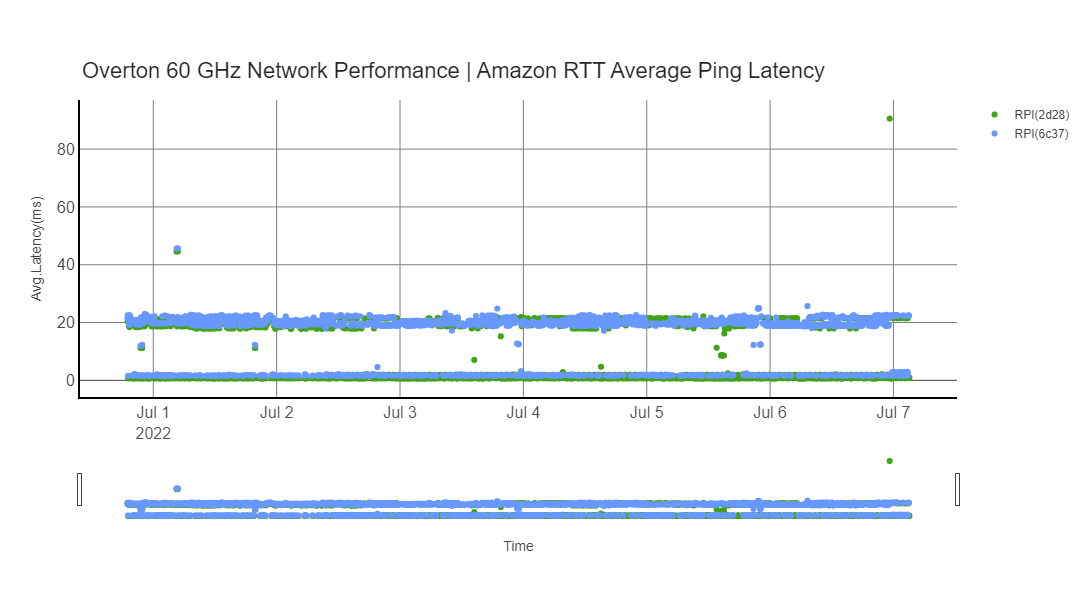

In [21]:
plot_latencytest_trend(
    df = df2, 
    x_col = 'datetime', 
    y_col = 'amazon_rtt_avg_ms', 
    title = 'Overton 60 GHz Network Performance | Amazon RTT Average Ping Latency'
)

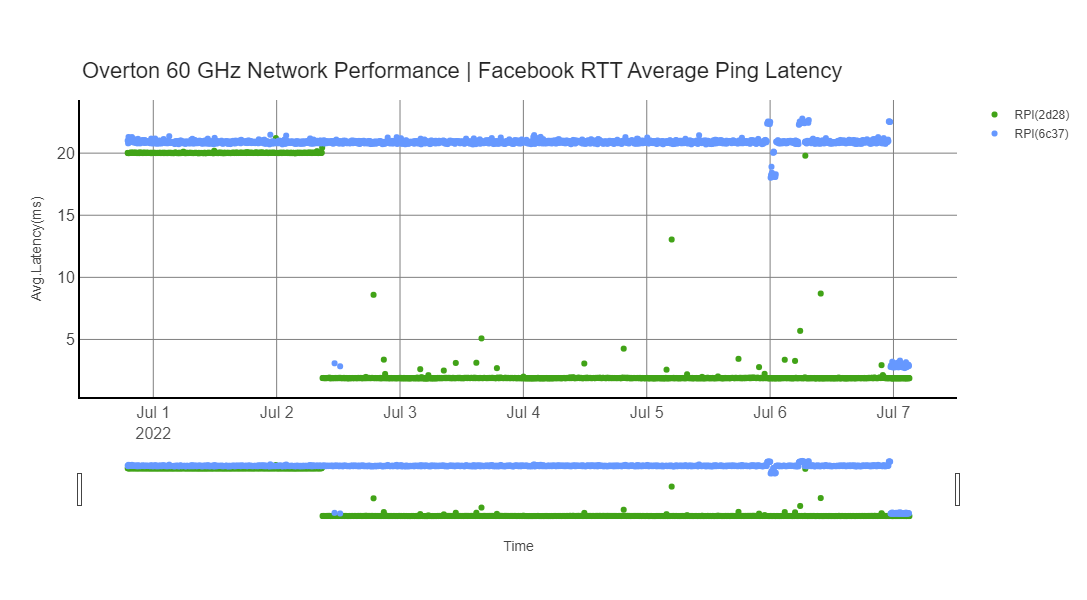

In [22]:
plot_latencytest_trend(
    df = df2, 
    x_col = 'datetime', 
    y_col = 'facebook_rtt_avg_ms', 
    title = 'Overton 60 GHz Network Performance | Facebook RTT Average Ping Latency'
)

In [23]:
plot_latencytest_trend(
    df = df2, 
    x_col = 'datetime', 
    y_col = 'google_rtt_avg_ms', 
    title = 'Overton 60 GHz Network Performance | Google RTT Average Ping Latency'
)

### Last Mile Latency

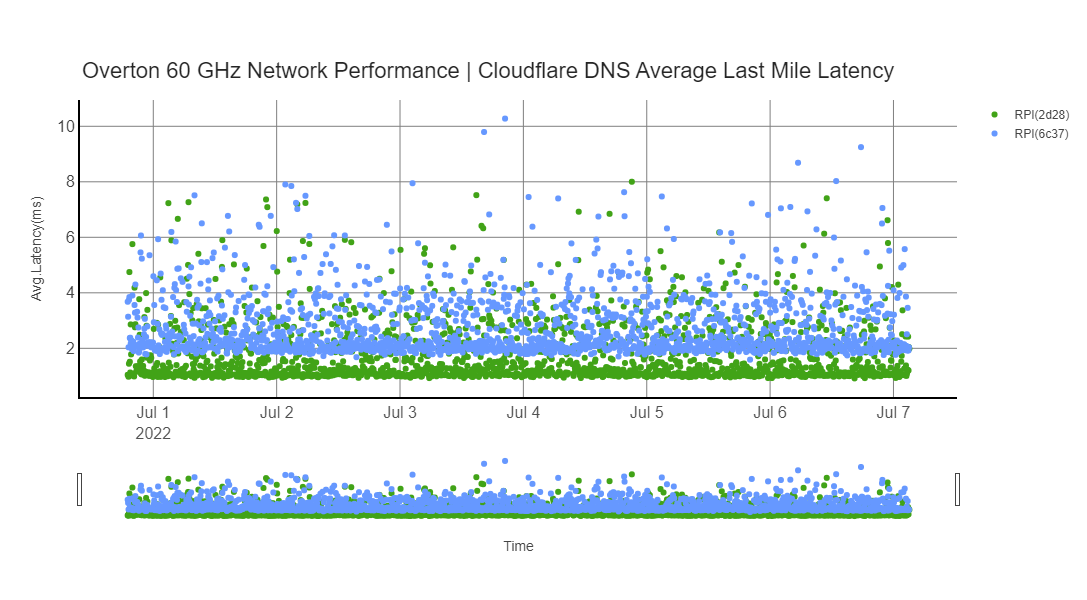

In [20]:
plot_latencytest_trend(
    df = df2, 
    x_col = 'datetime', 
    y_col = 'Cloudflare_DNS_last_mile_ping_rtt_avg_ms', 
    title = 'Overton 60 GHz Network Performance | Cloudflare DNS Average Last Mile Latency'
)